## Problem: FOBO breaks for PnL data sent to DRD

    - Pnl diff b/w Oscar and TITAN
    - Inputs: Static Data, Market data, Price difference (foxhound vs Bloomberg)
    - Data avialiability
    - Data Quality
    - FOFO break is typically b/w TITAN and Oscar
    - FOBO break is typically b/w TITAN and ?
    - It was proposed that TITAN in the future will do accrual accouting/clean price-based (simple price*quantity) and fair value valuation
    
    

Data Problems are for ML solutions:

    - Checking the correctnesss/quality of GRV data
        * Correlation b/w CS01 and IRDelta 
    - Correctness of attribution/RBPL explain data is correct
    - problem need to be solve, value proposition, success criteria. approach (steps) etc
    - this should be come a template where going forward people should think along these lines not just "oh i have a idea!"


# Introduction to Anomaly Detection Models
    - Using Density Based Spacial Clustering Applications with Noise
    
By Ade Idowu

## Intro:
    - DBSCAN - Density Based Spacial Clustering Application with Noise is an unsupervised clustring algorthm
    - It requires the specification of 2 hyper-parameters namely:
        * eps: maximum distance between two samples for them to be considered as in the same neighborhood.
        * min_samples: number of samples (or total weight) in a neighborhood for a point to be considered as a core point
    - The output of this algorthm are 3 clusters, namely:
        * core points
        * (density-) reachable points 
        * outliers

## Description of DBSCAN algorithm

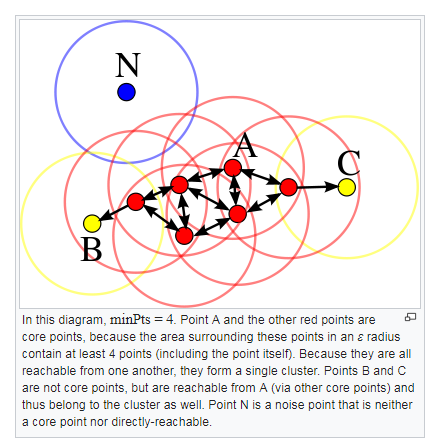

In [1]:
from IPython.display import Image
Image(filename = "DBSCAN_neighborhood_point_description.PNG", width=500, height=500)

## Demos:
    - Demo 1: Simple toy demo
    - Demo2: A slighly more realistic demo using RB05/RB06 bonds data (TBC)

### Demo1 : Simple toy Demo

### Define imports

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
simple_data = [[1, 2], [200, 120], [2, 3],
              [8, 7], [8, 8], [170, -80], [30, 29]]

In [4]:
from sklearn.datasets import make_classification
XX, yy = make_classification(n_samples = 100, 
                             n_features= 2, 
                             n_informative=2, 
                             n_redundant=0, 
                             n_clusters_per_class=1,
                            weights=[0.9,0.1],
                            class_sep=0.7,
                            random_state= 10)

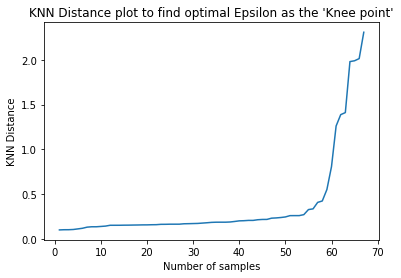

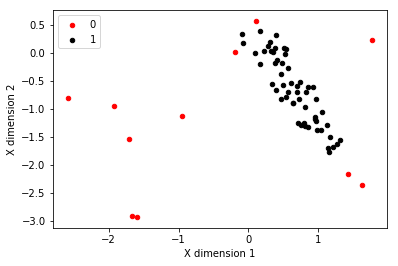

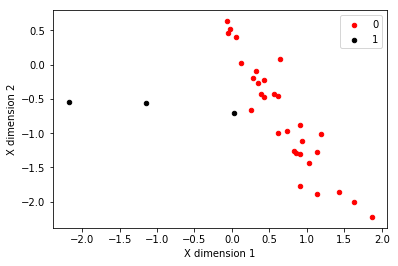

Predicted labels are: [ 0 -1  0 -1 -1  0  1  0  1 -1 -1 -1 -1  0  1 -1  1  0 -1  0 -1  0 -1  1
  1 -1  1  1  1  1  0  0 -1]


In [5]:
def plotGraphs(X, y):
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {1:'black', 0:'red'}
    fig, ax = plt.subplots()    
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.xlabel("X dimension 1")
    plt.ylabel("X dimension 2")
    plt.show()
    
def createLabelsMask(model, labels):
    core_samples = np.zeros_like(labels, dtype = bool)
    core_samples[model.core_sample_indices_] = True
    labels_mask=list(core_samples)
    return np.asarray(labels_mask)
    
def findOutlierPoint(X, labels_mask):
    new_X = X[labels_mask == True]
    outliers = X[labels_mask == False]
    return new_X, outliers

def findKneePiont(data, min_samples):
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distanceDec = sorted(distances[:,min_samples-1], reverse=False)
    plt.plot(list(range(1,len(data)+1)), distanceDec)
    plt.title("KNN Distance plot to find optimal Epsilon as the 'Knee point'")
    plt.xlabel("Number of samples")
    plt.ylabel("KNN Distance")
    plt.show()

def runModel(data, min_samples=2, eps=5,is_print=False):
    findKneePiont(data, min_samples)
    X = np.asarray(data)
    model = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = model.labels_
    labels_mask = createLabelsMask(model, labels)
    new_X, outliers = findOutlierPoint(X, labels_mask)
    yy = labels_mask.astype(int)
    y = model.fit_predict(X)
    if is_print:
        print("All points: {}".format(data))
        print("Good Points are: {}".format(new_X))
        print("Outlier points are: {}".format(outliers))
        print("Labels: {}".format(y))
    plotGraphs(X, yy)
    return model
   
#runModel(simple_data)
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.33, random_state=42)
dbscan_model = runModel(X_train,min_samples=5, eps=0.35)
labels = dbscan_model.fit_predict(X_test)
plotGraphs(X_test, y_test)
print("Predicted labels are: {}".format(labels))

### Simple Autoencoder Noise detector on toy data

In [61]:
import pandas as pd
import pickle
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [82]:
def buildAEModel():
    input_dim = X_train.shape[1]
    encoding_dim = 4
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)
    model = Model(inputs=input_layer, outputs=decoder)
    return model

def trainAEModel(model):
    nb_epoch = 500
    batch_size = 20
    model.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
    history = model.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1)
    checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
    return history

def evaluateAEModel(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
def predictAnomalyDetectionResults(model):
    predictions = model.predict(X_test)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
    return error_df

In [83]:
model = buildAEModel()
history = trainAEModel(model)

Train on 67 samples, validate on 33 samples
Epoch 1/500
67/67 [==============================] - 0s - loss: 1.0424 - acc: 0.5970 - val_loss: 0.9828 - val_acc: 0.8182
Epoch 2/500
67/67 [==============================] - 0s - loss: 1.0377 - acc: 0.8806 - val_loss: 0.9779 - val_acc: 0.8182
Epoch 3/500
67/67 [==============================] - 0s - loss: 1.0335 - acc: 0.8955 - val_loss: 0.9738 - val_acc: 0.8182
Epoch 4/500
67/67 [==============================] - 0s - loss: 1.0300 - acc: 0.8955 - val_loss: 0.9701 - val_acc: 0.8182
Epoch 5/500
67/67 [==============================] - 0s - loss: 1.0285 - acc: 0.8955 - val_loss: 0.9671 - val_acc: 0.8182
Epoch 6/500
67/67 [==============================] - 0s - loss: 1.0256 - acc: 0.8955 - val_loss: 0.9647 - val_acc: 0.8182
Epoch 7/500
67/67 [==============================] - 0s - loss: 1.0229 - acc: 0.8955 - val_loss: 0.9627 - val_acc: 0.8182
Epoch 8/500
67/67 [==============================] - 0s - loss: 1.0213 - acc: 0.8955 - val_loss: 0.961

67/67 [==============================] - 0s - loss: 1.0158 - acc: 0.6269 - val_loss: 0.9502 - val_acc: 0.9091
Epoch 132/500
67/67 [==============================] - 0s - loss: 1.0157 - acc: 0.9104 - val_loss: 0.9502 - val_acc: 0.9091
Epoch 133/500
67/67 [==============================] - 0s - loss: 1.0156 - acc: 0.8806 - val_loss: 0.9501 - val_acc: 0.9091
Epoch 134/500
67/67 [==============================] - 0s - loss: 1.0156 - acc: 0.8806 - val_loss: 0.9501 - val_acc: 0.9091
Epoch 135/500
67/67 [==============================] - 0s - loss: 1.0154 - acc: 0.8806 - val_loss: 0.9501 - val_acc: 0.9091
Epoch 136/500
67/67 [==============================] - 0s - loss: 1.0153 - acc: 0.8806 - val_loss: 0.9501 - val_acc: 0.9091
Epoch 137/500
67/67 [==============================] - 0s - loss: 1.0153 - acc: 0.8806 - val_loss: 0.9500 - val_acc: 0.9091
Epoch 138/500
67/67 [==============================] - 0s - loss: 1.0152 - acc: 0.8806 - val_loss: 0.9500 - val_acc: 0.9091
Epoch 139/500
67/67 [=

67/67 [==============================] - 0s - loss: 0.7599 - acc: 0.8806 - val_loss: 0.6827 - val_acc: 0.8182
Epoch 264/500
67/67 [==============================] - 0s - loss: 0.7590 - acc: 0.8806 - val_loss: 0.6815 - val_acc: 0.8182
Epoch 265/500
67/67 [==============================] - 0s - loss: 0.7581 - acc: 0.8806 - val_loss: 0.6805 - val_acc: 0.8182
Epoch 266/500
67/67 [==============================] - 0s - loss: 0.7572 - acc: 0.8806 - val_loss: 0.6796 - val_acc: 0.8182
Epoch 267/500
67/67 [==============================] - 0s - loss: 0.7565 - acc: 0.8806 - val_loss: 0.6786 - val_acc: 0.8182
Epoch 268/500
67/67 [==============================] - 0s - loss: 0.7557 - acc: 0.8806 - val_loss: 0.6777 - val_acc: 0.8182
Epoch 269/500
67/67 [==============================] - 0s - loss: 0.7551 - acc: 0.8806 - val_loss: 0.6767 - val_acc: 0.8182
Epoch 270/500
67/67 [==============================] - 0s - loss: 0.7543 - acc: 0.8806 - val_loss: 0.6758 - val_acc: 0.8182
Epoch 271/500
67/67 [=

67/67 [==============================] - 0s - loss: 0.7376 - acc: 0.8806 - val_loss: 0.6485 - val_acc: 0.8182
Epoch 394/500
67/67 [==============================] - 0s - loss: 0.7376 - acc: 0.8806 - val_loss: 0.6485 - val_acc: 0.8182
Epoch 395/500
67/67 [==============================] - 0s - loss: 0.7375 - acc: 0.8806 - val_loss: 0.6484 - val_acc: 0.8182
Epoch 396/500
67/67 [==============================] - 0s - loss: 0.7376 - acc: 0.8806 - val_loss: 0.6484 - val_acc: 0.8182
Epoch 397/500
67/67 [==============================] - 0s - loss: 0.7375 - acc: 0.8806 - val_loss: 0.6483 - val_acc: 0.8182
Epoch 398/500
67/67 [==============================] - 0s - loss: 0.7375 - acc: 0.8806 - val_loss: 0.6483 - val_acc: 0.8182
Epoch 399/500
67/67 [==============================] - 0s - loss: 0.7375 - acc: 0.8806 - val_loss: 0.6482 - val_acc: 0.8182
Epoch 400/500
67/67 [==============================] - 0s - loss: 0.7374 - acc: 0.8806 - val_loss: 0.6482 - val_acc: 0.8182
Epoch 401/500
67/67 [=

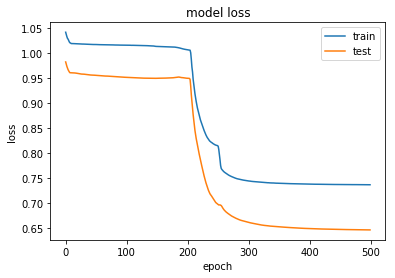

In [84]:
evaluateAEModel(history)

In [85]:
predictAnomalyDetectionResults(model)

,reconstruction_error,true_class
0,0.107161,0
1,2.521943,1
2,0.113991,0
3,0.207281,0
4,0.084858,0
5,0.219203,0
6,0.507702,0
7,0.017775,0
8,0.857196,0
9,1.561094,0


### Specify the data

In [2]:
#!mkdir -p Data
#!wget -c -b "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale customers data.csv" -P Data
data = pd.read_csv("Wholesale_customers_data.csv")
print(data.head())


   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


### Further exploration of the data

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB
None


### Descriptive stats of the data

In [4]:
print(data.describe())

          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000        256.750000    408.

### Let us do some feature extration on the data - by dropping some irrelevant fields

In [5]:
#data.drop(["Channel", "Region"], axis = 1, inplace = True)
print(data.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


### Let's plot the data now

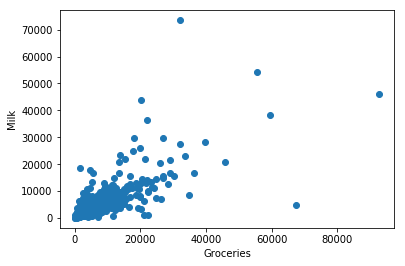

In [6]:
x = data['Grocery']
y = data['Milk']

plt.scatter(x,y)
plt.xlabel("Groceries")
plt.ylabel("Milk")
plt.show()

### Let us transform the data as a matrix

In [7]:
data = data[["Grocery", "Milk"]]
data = data.as_matrix().astype("float32", copy = False)

### Let us re-scale the data

In [8]:
stscaler = StandardScaler().fit(data)
data = stscaler.transform(data)

### Now let us use the DBSCAN method to detect the anomalies

In [9]:
dbsc = DBSCAN(eps = .5, min_samples = 15).fit(data)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

### Plot the result

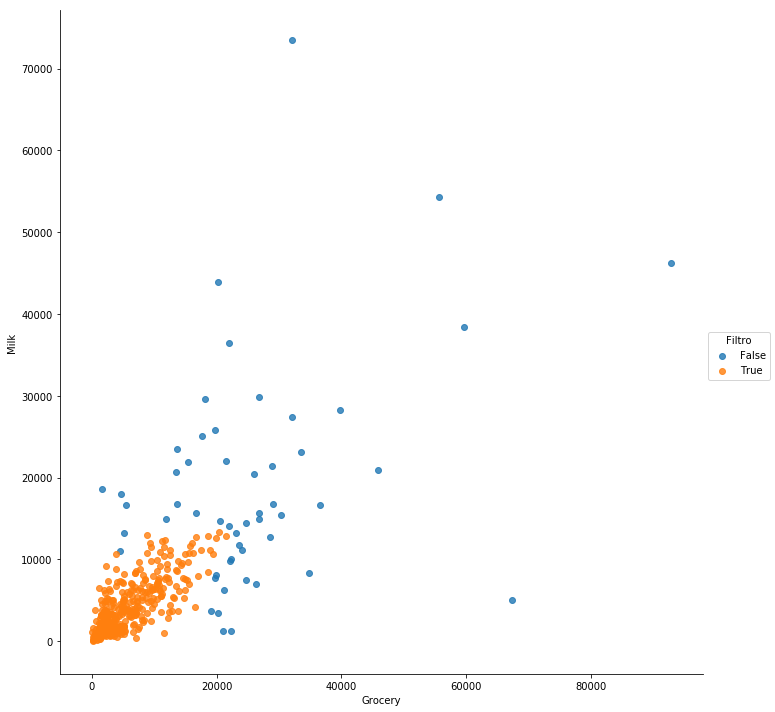

In [11]:
def plotDataWithDetectedAnomaly():
    data_test = pd.read_csv("Wholesale_customers_data.csv")
    import seaborn as sns
    filtro=list(core_samples)
    data_test["Filtro"]=filtro

    sns.lmplot("Grocery","Milk",data=data_test,fit_reg=False,hue="Filtro",size=10)
    plt.show()

plotDataWithDetectedAnomaly()

In [ ]:
y = np.asarray([[1,2], [2,2], [3,3], [4,4], [5,5], [6,6]])
x = np.asarray([ True,  True,  True,  True,  True, False]);
#np.where(x == False)
y[x == False]